In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%%time
df_begin = pd.read_csv("total_district.txt",
                      names=['taxi_id','date_time','long','lat','district'])
df_begin['datetime'] = pd.to_datetime(df_begin['date_time'],format = '%Y-%m-%d %X')
df_begin = df_begin.set_index('datetime')
df_begin.drop(['long','lat','date_time'], axis = 1, inplace = True)
print(df_begin.head())

                     taxi_id  district
datetime                              
2008-02-02 15:36:08        1  Chaoyang
2008-02-02 15:46:08        1  Chaoyang
2008-02-02 15:46:08        1  Chaoyang
2008-02-02 15:56:08        1  Chaoyang
2008-02-02 16:06:08        1  Chaoyang
CPU times: user 1min 29s, sys: 2.6 s, total: 1min 31s
Wall time: 1min 31s


In [4]:
%%time
#Prevision for every 10 minutes
df = df_begin.groupby([pd.Grouper(level='datetime', freq='10Min'),
                      "district"])[['taxi_id']].count().reset_index()

CPU times: user 37.4 s, sys: 1 s, total: 38.4 s
Wall time: 38.4 s


In [5]:
df.head()

,datetime,district,taxi_id
0,2008-02-02 13:30:00,Changping,72
1,2008-02-02 13:30:00,Chaoyang,4335
2,2008-02-02 13:30:00,Chongwen,2624
3,2008-02-02 13:30:00,Daxing,177
4,2008-02-02 13:30:00,Dongcheng,2808


In [6]:
df.datetime = pd.to_datetime(df.datetime,format = '%Y-%m-%d %X')
df.columns=['datetime','district','taxi_count']

In [7]:
import requests
from bs4 import BeautifulSoup
from tabulate import tabulate

In [8]:
res = requests.get("https://www.sunrise-and-sunset.com/en/sun/china/beijing/2008/february/2")
soup = BeautifulSoup(res.content,'lxml')
all_tables=soup.find_all("table")

In [9]:
df_sunrise = pd.read_html(str(all_tables[1]))[0][1:8].reset_index()

In [10]:
df_sunrise.drop('index',axis=1,inplace=True)

/home/pranav/.local/lib/python3.5/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


In [11]:
df_sunrise.columns=["Day","Sunrise","Sunset","Day Lenght"]

In [12]:
df_sunrise

,Day,Sunrise,Sunset,Day Lenght
0,"2 February 2008, Saturday",07:23,17:32,10:09
1,"3 February 2008, Sunday",07:22,17:34,10:11
2,"4 February 2008, Monday",07:21,17:35,10:13
3,"5 February 2008, Tuesday",07:20,17:36,10:15
4,"6 February 2008, Wednesday",07:19,17:37,10:17
5,"7 February 2008, Thursday",07:18,17:38,10:20
6,"8 February 2008, Friday",07:17,17:40,10:22


In [14]:
df_sunrise = pd.concat([df_sunrise,pd.DataFrame([day.split(',') for day in df_sunrise.Day])],
                        axis=1,ignore_index=True)
df_sunrise.columns=["Day","Sunrise","Sunset","Day Length","Date","WeekDay"]
df_sunrise.Date = pd.to_datetime(df_sunrise.Date)

In [15]:
df_sunrise.Date = pd.to_datetime(df_sunrise.Date)

In [16]:
df_sunrise

,Day,Sunrise,Sunset,Day Length,Date,WeekDay
0,"2 February 2008, Saturday",07:23,17:32,10:09,2008-02-02,Saturday
1,"3 February 2008, Sunday",07:22,17:34,10:11,2008-02-03,Sunday
2,"4 February 2008, Monday",07:21,17:35,10:13,2008-02-04,Monday
3,"5 February 2008, Tuesday",07:20,17:36,10:15,2008-02-05,Tuesday
4,"6 February 2008, Wednesday",07:19,17:37,10:17,2008-02-06,Wednesday
5,"7 February 2008, Thursday",07:18,17:38,10:20,2008-02-07,Thursday
6,"8 February 2008, Friday",07:17,17:40,10:22,2008-02-08,Friday


In [17]:
#Just save it in case the site goes down we have a backup
df_sunrise.to_csv("sunrise_timing_beijing.csv",index=None)

In [18]:
def is_sun_up(data,sunrise_table):
    detail  = sunrise_table[data.date()==sunrise_table.Date.dt.date].reset_index()
    sunrise = pd.to_datetime(detail['Date'].dt.date.apply(str)+" "+detail['Sunrise'])
    sunset  = pd.to_datetime(detail['Date'].dt.date.apply(str)+" "+detail['Sunset'])
    if ((sunrise < data) & (data < sunset))[0]:
        return 1
    else:
        return 0

In [19]:
def day_period(time):
    hour = time.hour
    if(0<=hour<=5 or hour>=23):
        return "Night"
    if(6<=hour<=12):
        return "Morning"
    if(12<hour<=18):
        return "Afternoon"
    if(18<hour<23):
        return "Evening"
    
def is_time_to_eat(time):
    hour = time.hour
    if(6<=hour<=9 or 12<=hour<=14 or 18<=hour<=21):
        return 1 #yes
    else:
        return 0 #no

In [20]:
%%time
#df["period"] = df.datetime.apply(day_period)
#I find more interesting this way, atleast there is some data behind it to
#justify, defining the Morning, Evening like we did before cannot be easily
#justified.
df["is_sun_up"]  = df.datetime.apply(lambda x: is_sun_up(x,df_sunrise)) 
df["time_to_eat"] = df.datetime.apply(is_time_to_eat)

CPU times: user 1min 52s, sys: 52 ms, total: 1min 52s
Wall time: 1min 52s


In [21]:
#In the LSTM I don't actually need it the extra variable,
#just keeping them in case you guys need it
df.head(20)

,datetime,district,taxi_count,is_sun_up,time_to_eat
0,2008-02-02 13:30:00,Changping,72,1,1
1,2008-02-02 13:30:00,Chaoyang,4335,1,1
2,2008-02-02 13:30:00,Chongwen,2624,1,1
3,2008-02-02 13:30:00,Daxing,177,1,1
4,2008-02-02 13:30:00,Dongcheng,2808,1,1
5,2008-02-02 13:30:00,Fangshan,82,1,1
6,2008-02-02 13:30:00,Fengtai,2035,1,1
7,2008-02-02 13:30:00,Haidian,2209,1,1
8,2008-02-02 13:30:00,Huairou,14,1,1
9,2008-02-02 13:30:00,Mentougou,21,1,1


In [22]:
time_series = df.groupby('datetime')['taxi_count'].sum()

In [23]:
time_series = pd.DataFrame(time_series).reset_index()

In [24]:
%%time
time_series["is_sun_up"]  = time_series.datetime.apply(lambda x: is_sun_up(x,df_sunrise)) 
time_series["time_to_eat"] = time_series.datetime.apply(is_time_to_eat)

CPU times: user 6.4 s, sys: 12 ms, total: 6.41 s
Wall time: 6.37 s


In [25]:
time_series.set_index('datetime',inplace=True)

In [26]:
time_series.head()

,taxi_count,is_sun_up,time_to_eat
datetime,,,
2008-02-02 13:30:00,19721,1,1
2008-02-02 13:40:00,28444,1,1
2008-02-02 13:50:00,28627,1,1
2008-02-02 14:00:00,25055,1,1
2008-02-02 14:10:00,24114,1,1


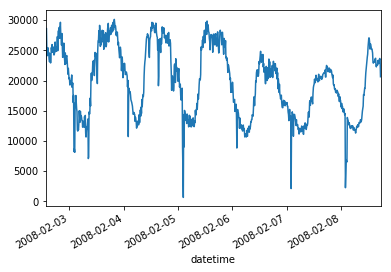

In [27]:
time_series.taxi_count.plot()
plt.show()

# Here is the LSTM

In [29]:
time_series_simple = time_series.iloc[:,0:1].values

In [30]:
train, test = time_series_simple[0:-80], time_series_simple[-80:]

In [31]:
train.shape

(806, 1)

In [32]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [33]:
scaler = MinMaxScaler(feature_range=(0,1))
#They work better in this range (0,1)
train_scaled = scaler.fit_transform(train) 

In [34]:
train_scaled[1:5]

array([[0.94297546],
       [0.94918706],
       [0.82794203],
       [0.79600149]])

In [35]:
features_set = []  
labels = []  
#Use 60 records to predict to next one
for i in range(60, len(train_scaled)):  
    features_set.append(train_scaled[i-60:i, 0])
    labels.append(train_scaled[i, 0])

In [36]:
# We need them as np array
features_set, labels = np.array(features_set), np.array(labels)  

In [37]:
features_set = np.reshape(features_set, 
                          (features_set.shape[0], 
                           features_set.shape[1], 
                           1))  #Using only one feature

In [38]:
features_set.shape

(746, 60, 1)

In [39]:
from keras.models import Sequential  
from keras.layers import Dense  
from keras.layers import LSTM  
from keras.layers import Dropout 

Using TensorFlow backend.


In [40]:
model = Sequential()  
model.add(LSTM(units=50, return_sequences=True, 
               input_shape=(features_set.shape[1], 1)))  
model.add(Dropout(0.2))  #Can be changed later, used to avoid overfitting
#Deep Learning
model.add(LSTM(units=50, return_sequences=True))  
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))  
model.add(Dropout(0.2))

model.add(LSTM(units=50))  
model.add(Dropout(0.2))  

#output
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

W0626 18:51:17.428379 140102607296256 deprecation_wrapper.py:119] From /home/pranav/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0626 18:51:17.443118 140102607296256 deprecation_wrapper.py:119] From /home/pranav/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0626 18:51:17.445663 140102607296256 deprecation_wrapper.py:119] From /home/pranav/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0626 18:51:17.729534 140102607296256 deprecation_wrapper.py:119] From /home/pranav/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_defa

In [42]:
%%time
model.fit(features_set,labels,epochs=100,batch_size=35)

Epoch 1/100
746/746 [==============================] - 4s 6ms/step - loss: 0.0123
Epoch 2/100
746/746 [==============================] - 4s 6ms/step - loss: 0.0101
Epoch 3/100
746/746 [==============================] - 5s 6ms/step - loss: 0.0107
Epoch 4/100
746/746 [==============================] - 5s 6ms/step - loss: 0.0102
Epoch 5/100
746/746 [==============================] - 5s 7ms/step - loss: 0.0096
Epoch 6/100
746/746 [==============================] - 5s 6ms/step - loss: 0.0112
Epoch 7/100
746/746 [==============================] - 5s 6ms/step - loss: 0.0099
Epoch 8/100
746/746 [==============================] - 5s 7ms/step - loss: 0.0096
Epoch 9/100
746/746 [==============================] - 5s 6ms/step - loss: 0.0095
Epoch 10/100
746/746 [==============================] - 5s 6ms/step - loss: 0.0093
Epoch 11/100
746/746 [==============================] - 5s 7ms/step - loss: 0.0092
Epoch 12/100
746/746 [==============================] - 5s 7ms/step - loss: 0.0094
Epoch 13/100


746/746 [==============================] - 4s 6ms/step - loss: 0.0055
Epoch 100/100
746/746 [==============================] - 4s 6ms/step - loss: 0.0055
CPU times: user 25min 34s, sys: 2min 57s, total: 28min 31s
Wall time: 7min 50s


In [43]:
test.shape

(80, 1)

In [44]:
time_series_simple.shape

(886, 1)

In [45]:
total = time_series['taxi_count']

In [46]:
test_inputs = total[len(total)-len(test)-60:].values

In [47]:
test_inputs = test_inputs.reshape(-1,1)

In [48]:
#test_inputs = test_inputs.reshape(-1,1)

In [49]:
test_inputs = scaler.transform(test_inputs)

In [50]:
test_features = []  
for i in range(60, len(test_inputs)):  
    test_features.append(test_inputs[i-60:i, 0])

In [51]:
len(test_features)

80

In [52]:
test_features = np.array(test_features)

In [53]:
test_features = np.reshape(test_features, 
                           (test_features.shape[0], 
                            test_features.shape[1], 
                            1))  

In [54]:
predictions = model.predict(test_features)  

In [55]:
predictions = scaler.inverse_transform(predictions)

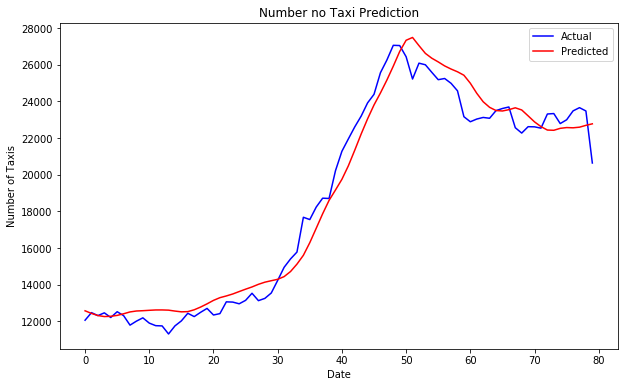

In [56]:
plt.figure(figsize=(10,6))  
plt.plot(test, color='blue', label='Actual')  
plt.plot(predictions , color='red', label='Predicted')  
plt.title('Number no Taxi Prediction')  
plt.xlabel('Date')  
plt.ylabel('Number of Taxis')  
plt.legend()  
plt.show()  